In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('paper')

# Set up an initial configuration in REBOUND

Let's set up a REBOUND simulation with three Earth-mass planets around a solar-mass star. The inner two planets' orbital periods are at the 3:2 MMR, while the outermost orbital period does not form any simple integer ratios with the inner two. Inclinations and eccentricities are a couple percent, and the inner two particles are initialized at the location where their orbits are spaced furthest apart.

In [2]:
import rebound
def get_sim():
    np.random.seed(1)
    sim = rebound.Simulation()
    sim.add(m=1)
 
    sim.G = 4*np.pi*np.pi
    mass=3e-6
    e=0.01
    inc=0.05
    
    sim.add(m=mass,P=1, e=0.02, pomega=0, theta=np.pi, inc=0.02)
    sim.add(m=mass,P=3/2, e=0.03, pomega=0, theta=np.pi, inc=0.03)
    sim.add(m=mass,P=3.2, e=0, pomega=0, theta=0)
    sim.move_to_com()
    
    sim.dt = sim.particles[1].P / 30.
    sim.integrator='whfast'
    return sim 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: cm


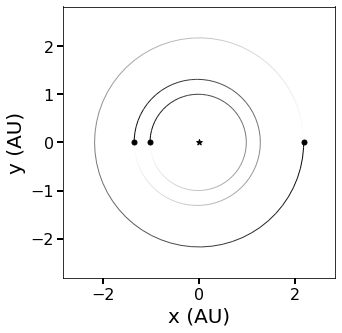

In [3]:
sim=get_sim()
fig, ax = rebound.OrbitPlot(sim)
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')
fig.savefig('fig1.pdf', dpi=300, bbox_inches='tight')

# Make a celmech model

Import Poincare variable functions from the celmech package

In [4]:
from celmech import Poincare, PoincareHamiltonian

Initialize model directly from the REBOUND simulation

In [5]:
sim=get_sim()
poincare_variables = Poincare.from_Simulation(sim)

A 'Poincare' object stores a set of particles with Poincare canonical coordinates:
\begin{align}
\Lambda_i = \mu_i\sqrt{G M_* a_i} &;& \lambda_i \\
X_i = \sqrt{2\Gamma_i}\cos(\gamma_i) &;& Y_i=\sqrt{2\Gamma_i}\sin(\gamma_i)
\end{align}
where 
\begin{align}
\Gamma_i = \Lambda_i(1-\sqrt{1-e_i^2}) &;& \gamma_i =-\varpi_i.
\end{align}
By default, celmech uses canonical heliocentric coordinates in a center of mass frame (e.g., Laskar \& Robutel 1995), in which case the appropriate masses are
\begin{align}
\mu_i = \frac{m_0 m_i}{m_0 + m_i} &;& M_i = m_0 + m_i \\
\end{align}

Now construct a Hamiltonian model with the Poincare varaibles:

In [6]:
Hp = PoincareHamiltonian(poincare_variables)

The 'Hamlitonian' object keeps track of a symbolic Hamiltonian. By default 𝑁 distinct Keplerian terms are included.

In [7]:
Hp.H

   2   2   3    2   2   3    2   2   3
  G ⋅M₃ ⋅μ₃    G ⋅M₂ ⋅μ₂    G ⋅M₁ ⋅μ₁ 
- ────────── - ────────── - ──────────
        2            2            2   
    2⋅Λ₃         2⋅Λ₂         2⋅Λ₁    


Now let's add the leading order terms for the 3:2 MMR between the inner two planets

In [8]:
Hp.add_MMR_terms(p=3, q=1, indexIn=1, indexOut=2)

In [9]:
Hp.df

<IPython.core.display.Math object>

In [10]:
%%time
Nout = 1000
tmax = 10000
e2, Ne2= np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0, tmax, Nout)
ps = sim.particles
for i, time in enumerate(times):
    Hp.integrate(time)
    sim.integrate(time)
    e2[i] = Hp.particles[2].e
    Ne2[i] = sim.particles[2].e

CPU times: user 2.19 s, sys: 8.08 ms, total: 2.2 s
Wall time: 2.2 s


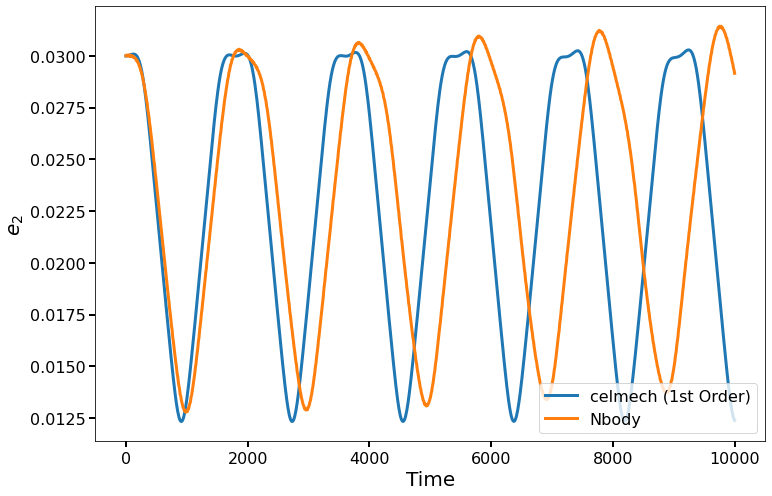

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, e2, label='celmech (1st Order)')
ax.plot(times, Ne2, label='Nbody')
ax.set_xlabel('Time')
ax.set_ylabel('$e_2$')
ax.legend(loc='lower right')
fig.savefig('firstorder.pdf', dpi=300, bbox_inches='tight')

# Osculating vs Mean Variables

One issue leading to the discrepancy above with N-body is our rather special initial conditions starting at conjunction. If we run a short N-body integration, we see that our initial semimajor axes are not representative of the typical or mean values, but rather are at the tops of the unrepresentative spikes at conjunctions

In [12]:
sim = get_sim()
a = np.zeros(Nout)
short_times = np.linspace(0, 10, Nout)
for i, time in enumerate(short_times):
    sim.integrate(time)
    a[i] = sim.particles[1].a

Text(0, 0.5, '$a_1$ (AU)')

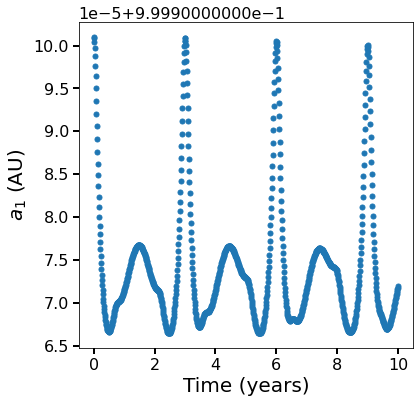

In [14]:
fig, ax = plt.subplots()
ax.plot(short_times, a, '.')
ax.set_xlabel('Time (years)')
ax.set_ylabel('$a_1$ (AU)')

One can deal with this issue is to go from "osculating" variables in the full problem (including the spikes) to "mean" variables, which average out those short-period effects to yield orbital elements that vary smoothly on long timescales.

The most elegant way to do that is through a near-identity canonical transformation using Lie series (see paper). We can set up this transformation by setting up our Hamiltonian like before, and then making a `FirstOrderGeneratingFunction`

In [21]:
from celmech.lie_transformations import FirstOrderGeneratingFunction

sim=get_sim()
poincare_variables = Poincare.from_Simulation(sim)
Hp = PoincareHamiltonian(poincare_variables)
Hp.add_MMR_terms(p=3, q=1, max_order=2, indexIn=1, indexOut=2)

chi = FirstOrderGeneratingFunction(poincare_variables)

We now need to add all the fast terms in the disturbing function we want to average over. It turns out the terms leading to the spikes at conjunctions can be summed into a single term, which is zeroth-order in (i.e., does not involve) the eccentricities and inclinations. We can add it through

In [22]:
chi.add_zeroth_order_term()

This is the most important term to add, given our setup at conjunction. Our configuration is also special in that both cosine arguments initially evaluate to exactly zero. Because this leads to several derivatives that initially vanish, much smaller contributions from other nearby resonances (whose arguments do not evaluate to zero) matter slightly. We can correct for the adjacent first-order MMRs between the inner two planets (4:3 and 2:1) with

In [23]:
chi.add_MMR_terms(p=2,q=1,l_max=1, indexIn=1, indexOut=2)
chi.add_MMR_terms(p=4,q=1,l_max=1, indexIn=1, indexOut=2)

We then transform from osculating to mean variables and run our integration

In [24]:
%%time
chi.osculating_to_mean()
e2mean = np.zeros(Nout)
for i, time in enumerate(times):
    Hp.integrate(time)
    e2[i] = Hp.particles[2].e

CPU times: user 12 s, sys: 24.5 ms, total: 12 s
Wall time: 12 s


With this correction, we almost match the N-body oscillation frequency, though we can see that the shape of various peaks is still somewhat different

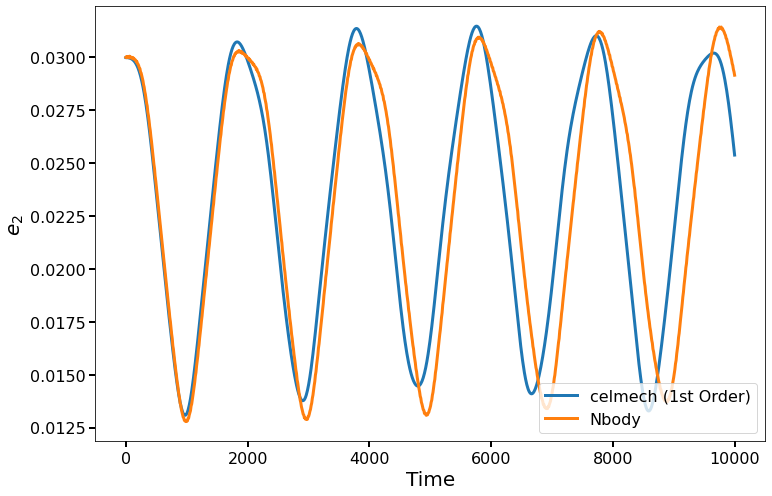

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, e2, label='celmech (1st Order)')
ax.plot(times, Ne2, label='Nbody')
ax.set_xlabel('Time')
ax.set_ylabel('$e_2$')
ax.legend(loc='lower right')
fig.savefig('firstorder.pdf', dpi=300, bbox_inches='tight')

# Going to Second Order

To get the shapes of the oscillations right, we need to go to higher order in the eccentricities and inclinations. We can do this easily by passing the `max_order` keyword to `add_MMR_terms`. To go to second order in the inclinations and eccentricities:

In [38]:
max_order = 2
sim=get_sim()
poincare_variables = Poincare.from_Simulation(sim)
Hp = PoincareHamiltonian(poincare_variables)

Hp.add_MMR_terms(p=3, q=1, max_order=2, indexIn=1, indexOut=2)
Hp.df

<IPython.core.display.Math object>

We have now included the second order 6:4 terms, which introduce the first inclination-dependent terms. We can also add the secular terms for every pair of planets (which only start appearing at second-order) with

In [39]:
for idx1 in range(1,sim.N):
    for idx2 in range(idx1+1,sim.N):# get all combinations of planets
        print('Adding secular terms for planets {0} and {1}'.format(idx1, idx2))
        Hp.add_secular_terms(max_order=max_order, indexIn=idx1, indexOut=idx2)
Hp.df

Adding secular terms for planets 1 and 2
Adding secular terms for planets 1 and 3
Adding secular terms for planets 2 and 3


<IPython.core.display.Math object>

# This is not very user friendly. Is there a way to incorporate this in the transformation from osculating to mean variables?

In [40]:
for idx1 in range(1,sim.N):
    for idx2 in range(idx1+1,sim.N):# get all combinations of planets
        Hp.add_cosine_term(k_vec=[0,0,0,0,0,0],max_order=0,l_max=1, indexIn=idx1, indexOut=idx2)

We then apply the same correction from osculating to mean variables and integrate our second-order celmech model

In [ ]:
%%time

chi = FirstOrderGeneratingFunction(poincare_variables)
chi.add_zeroth_order_term()
chi.add_MMR_terms(p=2,q=1,l_max=1, indexIn=1, indexOut=2)
chi.add_MMR_terms(p=4,q=1,l_max=1, indexIn=1, indexOut=2)
chi.osculating_to_mean()

e2_2 = np.zeros(Nout)
for i, time in enumerate(times):
    Hp.integrate(time)
    e2_2[i] = Hp.particles[2].e

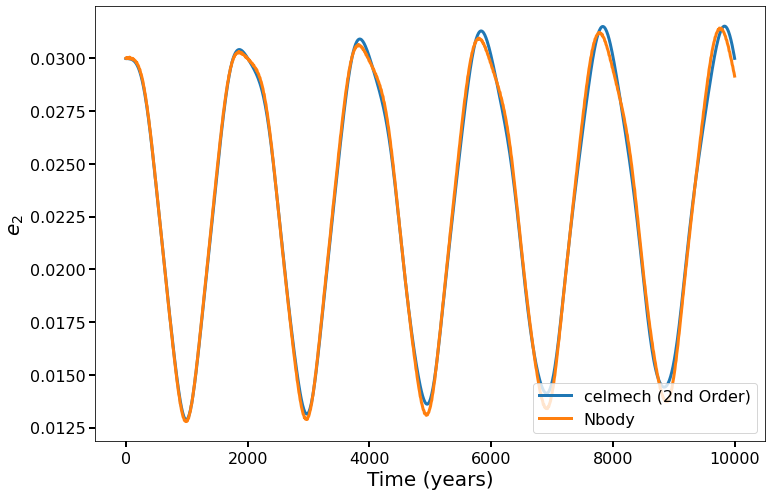

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, e2_2, lw=3, label='celmech (2nd Order)')
ax.plot(times, Ne2, lw=3, label='Nbody')
ax.set_xlabel('Time (years)')
ax.set_ylabel('$e_2$')
ax.legend(loc='lower right')
fig.savefig('secondorder.pdf', dpi=300, bbox_inches='tight')

The agreement for the eccentricities is now excellent. Unfortunately, the inclinations, which vary on a longer timescale (since the leading order terms are second order), are not as accurate. In order to match those closely, we need to go to third order in the eccentricities and inclinations, which is the lowest order including terms that directly couple the inclinations with the rapidly varying eccentricities. Let's therefore compare different-order approximations.

# Going to Higher Order

Let's begin by running a longer $10^5$ year integration (to capture a full inclination cycle of the middle planet) with both N-body and our above second-order model (a first-order model would have flat inclinations since there are no first-order inclination terms).

In [45]:
%%time
sim=get_sim()
poincare_variables = Poincare.from_Simulation(sim)

max_order = 2
Hp = PoincareHamiltonian(poincare_variables)
Hp.add_MMR_terms(p=3, q=1, max_order=max_order, indexIn=1, indexOut=2)
for idx1 in range(1,sim.N):
    for idx2 in range(idx1+1,sim.N):# get all combinations of planets
        Hp.add_secular_terms(max_order=max_order, indexIn=idx1, indexOut=idx2)
        Hp.add_cosine_term([0 for _ in range(6)],max_order=0,l_max=1, indexIn=idx1, indexOut=idx2)
chi = FirstOrderGeneratingFunction(poincare_variables)
chi.add_zeroth_order_term()
chi.add_MMR_terms(p=2,q=1,l_max=1, indexIn=1, indexOut=2)
chi.add_MMR_terms(p=4,q=1,l_max=1, indexIn=1, indexOut=2)
chi.osculating_to_mean()

Adding secular terms for planets 1 and 2
Adding secular terms for planets 1 and 3
Adding secular terms for planets 2 and 3
CPU times: user 3.81 s, sys: 5.99 ms, total: 3.82 s
Wall time: 3.81 s


In [46]:
%%time
tmax= 100000
i2_2, Ni2= np.zeros(Nout), np.zeros(Nout)
itimes = np.linspace(0, tmax, Nout)
ps = sim.particles
for i, time in enumerate(itimes):
    Hp.integrate(time)
    sim.integrate(time)
    i2_2[i] = Hp.particles[2].inc
    Ni2[i] = sim.particles[2].inc

In [53]:
%%time
max_order = 3

sim=get_sim()
poincare_variables = Poincare.from_Simulation(sim)
Hp = PoincareHamiltonian(poincare_variables)
Hp.add_MMR_terms(p=3, q=1, max_order=max_order, indexIn=1, indexOut=2)
for idx1 in range(1,sim.N):
    for idx2 in range(idx1+1,sim.N):# get all combinations of planets
        Hp.add_secular_terms(max_order=max_order, indexIn=idx1, indexOut=idx2)
        Hp.add_cosine_term([0 for _ in range(6)],max_order=0,l_max=1, indexIn=idx1, indexOut=idx2)
chi = FirstOrderGeneratingFunction(poincare_variables)
chi.add_zeroth_order_term()
chi.add_MMR_terms(p=2,q=1,l_max=1, indexIn=1, indexOut=2)
chi.add_MMR_terms(p=4,q=1,l_max=1, indexIn=1, indexOut=2)
chi.osculating_to_mean()

i2_3 = np.zeros(Nout)
for i, time in enumerate(itimes):
    Hp.integrate(time)
    i2_3[i] = Hp.particles[2].inc

CPU times: user 1min 19s, sys: 104 ms, total: 1min 19s
Wall time: 1min 19s


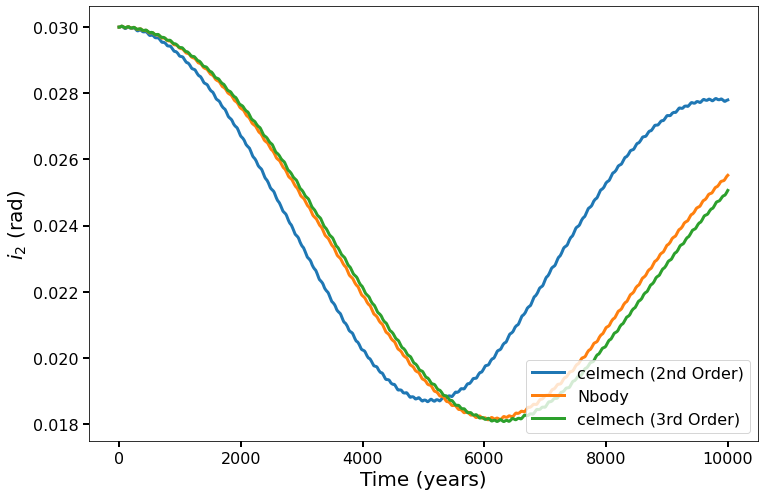

In [55]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, i2_2, lw=3, label='celmech (2nd Order)')
ax.plot(times, Ni2, lw=3, label='Nbody')
ax.plot(times, i2_3, lw=3, label='celmech (3rd Order)')
ax.set_xlabel('Time (years)')
ax.set_ylabel('$i_2$ (rad)')
ax.legend(loc='lower right')
fig.savefig('thirdorder.pdf', dpi=300, bbox_inches='tight')

# When going to higher order in the eccentricities and inclinations doesn't help

The reason why we could continue getting better agreement by going to higher order in the eccentricities and inclinations was the low masses of our planets. The ability we exploited above to go from osculating to mean variables through a canonical transformation is too good to be true rigorously. It is only correct to leading order in the planet-star mass ratio, and this correction introduces additional terms in the disturbing function at second order in the masses. 

Adding smaller and smaller terms in the eccentricities and inclinations only helps until they reach the size of the second-order mass terms. For higher mass planets, these second order mass terms can be important (see paper and references therein).

To finish, we can check how many terms are in our disturbing function at third order!

In [56]:
Hp.df

<IPython.core.display.Math object>